Initialization

In [224]:
import validators
import requests
from bs4 import BeautifulSoup
import re
import random

In [225]:
# Init Params
SUBJECT = 'Turing_Machine' # this will be a user input
BASE_URL = 'https://en.wikipedia.org/wiki/'
REQUEST_URL = 'https://en.wikipedia.org/api/rest_v1/page/html/'

MAX_TOPICS = 3
MAX_DEPTH = 3

In [226]:
class Topic:
    def __init__(self, name, link):
        self.name = name
        self.link = link

class Node:
    def __init__(self, parent, topic: Topic, related_topics, children):
        self.parent = parent # Node
        self.topic = topic # Topic
        self.related_topics = related_topics # Topic[]
        self.children = children # Node[]

Validation

In [227]:
def validate(base_url, topic):
    url = base_url+topic
    validation = validators.url(url)
    if validation:
        response = requests.get(url)
        print('URL: valid')
        if response.ok:
            print('Article: exists')
            return True
        else:
            print('Article: does not exist') 
            return False
    else:
        print('URL: invalid')
        return False

In [228]:
# Returns a BS4 object
def scrape(subject, base_url, request_url):
    if not validate(base_url, subject):
        return None

    r = requests.get(request_url + subject)
    soup = BeautifulSoup(r.content, 'html.parser')

    # reassign subject 
    subject = soup.find('title').string.lower()
    print('scrape(): ', subject)

    return soup

Data Cleaning

In [229]:
def clean(soup, subject, base_url, max_topics):

    topics = []
    for a in soup.select('a[rel^="mw:WikiLink"]'):
        topics.append(str(a.string))

    # Filter out isbn numbers
    isbn10_regex = '^\d{1,5}-\d{1,7}-\d{1,7}-[0-9X]$'
    isbn13_regex = '^(978|979)-\d{1,5}-\d{1,7}-\d{1,7}-\d$'
    topics = [re.sub(isbn10_regex, '', t) for t in topics]
    topics = [re.sub(isbn13_regex, '', t) for t in topics]

    topics = [s.lower() for s in topics]
    topics = [s for s in topics if s.strip() != '']
    #remove dups
    res = []
    [res.append(x) for x in topics if x not in res]
    topics = res

    # Misc Cleanup TODO
    topics = [s for s in topics if not s.endswith('(disambiguation)')] 
    topics = [s for s in topics if not s == subject] 

    # build valid dataset of 'topics'
    data = []
  
    index = 0
    for r in res:
        if validate(base_url, r):
            link = base_url + r
            topic = Topic(r, link)
            data.append(topic) 
            index += 1
        
        if index == max_topics:
            return data

Set Root

In [230]:
root_topic = Topic(SUBJECT, BASE_URL+SUBJECT)
root = Node(None, root_topic, [], [])

Build Graph

In [237]:
def build(root: Node, depth: int):
    if depth == MAX_DEPTH:
        return 
    subject = root.topic.name
    print("SUBJECT", subject, "Depth: ", depth)
    soup = scrape(subject, BASE_URL, REQUEST_URL)
    data = clean(soup, subject, BASE_URL, MAX_TOPICS)

    root.related_topics = data

    for i in root.related_topics:
        temp = Node(root, i, [], [])
        root.children.append(temp)
    
    for i in root.children:
        build(i, depth+1)

build(root, 0)

SUBJECT Turing_Machine Depth:  0
URL: valid
Article: exists
scrape():  turing machine
URL: invalid
URL: invalid
URL: invalid
URL: invalid
URL: invalid
URL: invalid
URL: invalid
URL: invalid
URL: invalid
URL: invalid
URL: invalid
URL: invalid
URL: invalid
URL: invalid
URL: invalid
URL: invalid
URL: invalid
URL: invalid
URL: invalid
URL: invalid
URL: valid
Article: exists
URL: valid
Article: exists
URL: invalid
URL: invalid
URL: invalid
URL: valid
Article: exists
SUBJECT v Depth:  1
URL: valid
Article: exists
scrape():  v
URL: invalid
URL: invalid
URL: invalid
URL: valid
Article: exists
URL: valid
Article: exists
URL: invalid
URL: valid
Article: exists
SUBJECT alphabetic Depth:  2
URL: valid
Article: exists
scrape():  alphabet
URL: invalid
URL: invalid
URL: valid
Article: exists
URL: valid
Article: exists
URL: valid
Article: exists
SUBJECT logographic Depth:  2
URL: valid
Article: exists
scrape():  logogram
URL: invalid
URL: valid
Article: exists
URL: invalid
URL: valid
Article: exists
U

In [232]:
for i in range(MAX_DEPTH):
    for child in root.children:
        print(child.topic.name)

v
t
discrete
v
t
discrete
v
t
discrete


In [233]:
def print_all_nodes(node: Node, indent: str = ""):
    print(indent + node.topic.name)
    for child in node.children:
        print_all_nodes(child, indent + "  ")  # Increase the indentation for child nodes

print_all_nodes(root)

Turing_Machine
  v
    alphabetic
      graphemes
      letters
      phonemes
    logographic
      lexicography
      greek
      word
    v
      alphabetic
      logographic
      v
  t
    letterform
      typography
      palaeography
      calligraphy
    tau
      tao
      t
      alpha
    ㅜ
      t
      hangul
      unicode
  discrete
    discreet
      discrete
      discreet
      none
    discrete
      discreet
      discrete
      quantum
    quantum
      physics
      interaction
      quantization


In [236]:
from graphviz import Digraph

# Create a Graphviz object
dot = Digraph(comment='Graph Visualization')

def add_nodes_and_edges(node, parent_node=None):
    # Add the current node
    dot.node(node.topic.name, label=node.topic.name)

    # Add an edge from the parent (if exists) to the current node
    if parent_node:
        dot.edge(parent_node.topic.name, node.topic.name)

    # Recursively add nodes and edges for children
    for child in node.children:
        add_nodes_and_edges(child, node)

# Add nodes and edges to the Graphviz object
add_nodes_and_edges(root)

# Render the graph to a file
dot.render("graph", view=True)

'graph.pdf'

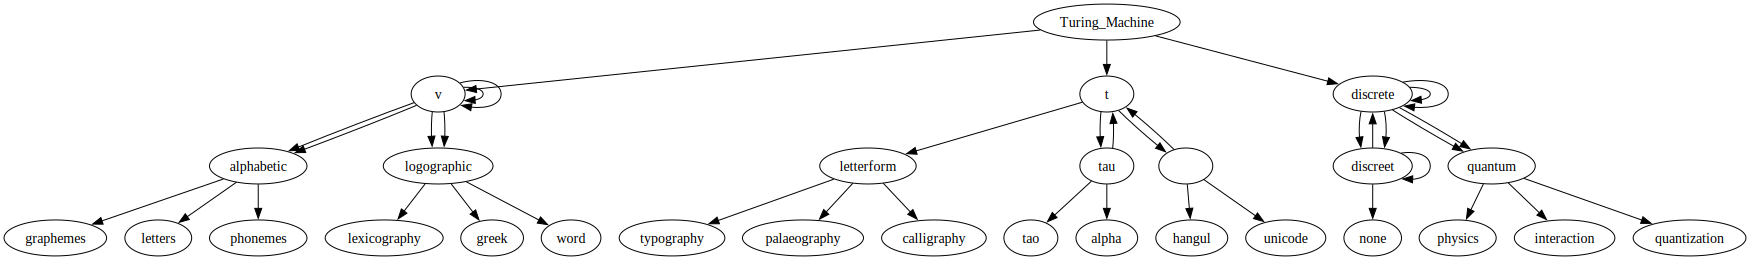

In [235]:
dot